### Import libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# Set the default font size for all text elements
plt.rcParams.update({'font.size': 10}) 

# You can also set specific elements:
plt.rcParams.update({'axes.titlesize': 11, 
                    'axes.labelsize': 10,
                      'xtick.labelsize': 9,
                      'ytick.labelsize': 9,
                      'legend.fontsize': 9})

### Define variables

In [22]:
#UPDATE
data_folder = "../generate_data/metad_lda"
output_folder = "outputs/metad"
os.makedirs(output_folder, exist_ok=True)

folders = [os.path.join(data_folder,fn) for fn in [ "bias_l1_h0.5_bf8_s0.4", "bias_l1_h0.9_bf8_s0.4", "bias_l1_h1.3_bf8_s0.4"]]
sim_frames = 200001 # 100 ns 
num_vars = 4  # time, ld1, phi, pdi and meta.rbias
num_fes_times = 5  # select every 10ns 
num_grids = 91
kt = 0.596161  # @T=300K


### load COLVAR data from different simulations

In [23]:
#colvar_data = np.empty([len(folders), num_vars, sim_frames])
all_cv_data = []
for folder in folders:
    cv_data = np.loadtxt(glob(os.path.join(folder,"*.cv.dat"))[0], usecols=(0,1,2,3,5)).T
    all_cv_data.append(cv_data)

colvar_data = np.array(all_cv_data)

### load data from phi-psi wt-metad simulation 

In [24]:
glob(os.path.join(data_folder,'bias_phipsi/*.cv.dat'))[0]
time_phipsi, ld1, phi_, psi_, meta_rbias = np.loadtxt(glob(os.path.join(data_folder,'bias_phipsi/*.cv.dat'))[0], usecols=(0,1,2,3,5), unpack=True)


$\textbf{calculate ld1 from phi-psi metad sim}$

In [25]:
h, g = np.histogram(ld1, bins=91, range=[-25,20], weights=np.exp(meta_rbias/kt))
b_phipsi = (g[1:]+g[:-1])/2
f_phipsi = -kt*np.log(h)
f_phipsi -= f_phipsi.min()

/state/partition1/job-66124232/ipykernel_3623166/345122919.py:3: RuntimeWarning: divide by zero encountered in log
  f_phipsi = -kt*np.log(h)


$\textbf{calculate 2d FES from phi-psi metad sim}$

/state/partition1/job-66124232/ipykernel_3623166/2042363416.py:5: RuntimeWarning: divide by zero encountered in log
  fe_ref = -kt*np.log(hist)


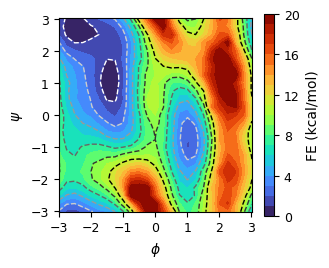

In [26]:
hist, xedges, yedges = np.histogram2d(phi_, psi_, bins=[25,25], density=True, weights=np.exp(meta_rbias/kt))
xcenters = (xedges[1:]+xedges[:-1])/2
ycenters = (yedges[1:]+yedges[:-1])/2
xx, yy = np.meshgrid(xcenters, ycenters)
fe_ref = -kt*np.log(hist)
fe_ref -= fe_ref.min()

#cap very large values at 20 kcal/mol
fe_ref[fe_ref>20]=20

fig, ax = plt.subplots(1, 1, figsize=(3.37,2.8))
im = ax.contourf(xx, yy, fe_ref.T, cmap='turbo', levels=21, vmin=0, vmax=20)
#im = ax.imshow(fe_ref.T,cmap='turbo',extent=(-np.pi,np.pi,-np.pi,np.pi),origin='lower',vmin=0,vmax=20)
ax.set_xticks(np.arange(-3,4))
ax.set_yticks(np.arange(-3,4))
ax.set_aspect('equal')
ax.contour(xx, yy, fe_ref.T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
cbar = fig.colorbar(im, ax=ax, ticks=np.arange(0,21,4))
cbar.set_label('FE (kcal/mol)')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

plt.tight_layout()
plt.savefig(os.path.join(output_folder,"fes_metad_phipsi.pdf"))

### Plot FE vs. LD1 obtained at multiple times

/state/partition1/job-66124232/ipykernel_3623166/2368391041.py:29: RuntimeWarning: divide by zero encountered in log
  f = -kt*np.log(h)


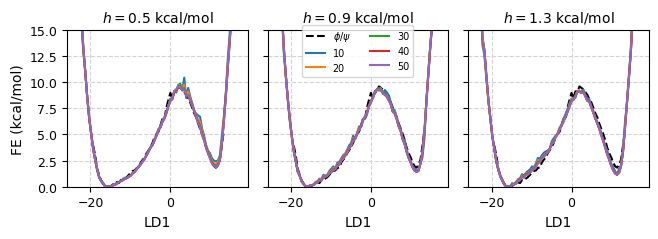

In [27]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6.69,2.5))
axs = axs.reshape([-1])  # Flatten the axes array for easier iteration

titles = ["$h=0.5$ kcal/mol","$h=0.9$ kcal/mol","$h=1.3$ kcal/mol"]


# Plot your data and collect handles and labels for the legend
handles = []
labels = []

for i in range(len(folders)):
    axs[i].set_ylim(0,15)
    axs[i].set_title(titles[i], fontsize=10)
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].set_xlabel('LD1')
 
    line, = axs[i].plot(b_phipsi, f_phipsi, 'k--', lw=1.5)
    if i==0:
        handles.append(line)
        labels.append('$\phi/\psi$')


    for j in range(num_fes_times):
        ld1 = colvar_data[i,1,:colvar_data.shape[2]*(j+1)//num_fes_times]
        meta_rbias = colvar_data[i,-1,:colvar_data.shape[2]*(j+1)//num_fes_times]

        h, g = np.histogram(ld1, bins=91, range=[-25,20], weights=np.exp(meta_rbias/kt))
        b = (g[1:]+g[:-1])/2
        f = -kt*np.log(h)
        f -= f.min()
        
        line, = axs[i].plot(b, f, label='%d ns'%((j+1)*10))
    #    # Only add to handles/labels once (since all subplots have same lines)
        if i == 0:  # Only for first subplot
            handles.append(line)
            labels.append('%d'%((j+1)*10))
    

    
# Adjust layout to make space for the legend
fig.tight_layout()
axs[0].set_ylabel('FE (kcal/mol)')

# Add a single legend for the entire figure
fig.legend(handles, labels, loc='lower center', 
           bbox_to_anchor=(0.542, 0.65),  # Adjust these values as needed
           ncol=2, fontsize='x-small')  # Adjust number of columns as needed

plt.tight_layout()
plt.savefig(os.path.join(output_folder,"compare_1d_fes_time.pdf"))

### plot 2d FES for different simulations, and compare to ref

/state/partition1/job-66124232/ipykernel_3623166/3213260201.py:13: RuntimeWarning: divide by zero encountered in log
  fe = -kt*np.log(hist)


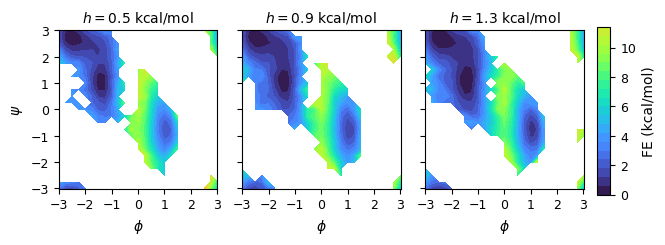

In [28]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(6.69,2.5))

axs = axs.reshape([-1])

for i in range(len(folders)):
    phi, psi = colvar_data[i, 2:4, :]
    wgts = np.exp(colvar_data[i,-1,:]/kt)
    
    hist, xedges, yedges = np.histogram2d(phi, psi, bins=[25,25], density=True, weights=wgts)
    xcenters = (xedges[1:]+xedges[:-1])/2
    ycenters = (yedges[1:]+yedges[:-1])/2
    xx, yy = np.meshgrid(xcenters, ycenters)
    fe = -kt*np.log(hist)
    fe -= fe.min()
    

    axs[i].set_xlabel("$\phi$")
    #axs[i].set_title(os.path.basename(folders[i]), fontsize=10)
    axs[i].set_title(titles[i], fontsize=10)

    im = axs[i].contourf(xx, yy, fe.T, cmap='turbo', levels=21,vmin=0,vmax=20)
    axs[i].set_xticks(np.arange(-3,4))
    axs[i].set_yticks(np.arange(-3,4))
    axs[i].set_aspect('equal')
#    axs[i].contour(xx, yy, fe.T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
axs[0].set_ylabel("$\psi$")
    
fig.tight_layout()    

# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.21, 0.02, 0.67])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0,16,2))

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
fig.subplots_adjust(right=0.88)
plt.savefig(os.path.join(output_folder,"fes_metad_from_metad_lda.pdf"))

### scatter plot: comparing 2d fes with reference FE

/state/partition1/job-66124232/ipykernel_3623166/419396606.py:11: RuntimeWarning: divide by zero encountered in log
  fe = -kt*np.log(hist)


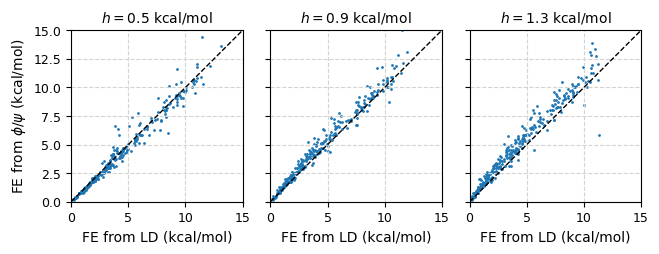

In [29]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6.69,2.5))

for i in range(len(folders)):
    phi, psi = colvar_data[i, 2:4, :]
    wgts = np.exp(colvar_data[i,-1,:]/kt)
    
    hist, xedges, yedges = np.histogram2d(phi, psi, bins=[25,25], density=True, weights=wgts)
    xcenters = (xedges[1:]+xedges[:-1])/2
    ycenters = (yedges[1:]+yedges[:-1])/2
    xx, yy = np.meshgrid(xcenters, ycenters)
    fe = -kt*np.log(hist)
    fe -= fe.min()
    
    axs[i].set_xlim(0,15)
    axs[i].set_ylim(0,15)
    axs[i].plot(np.arange(16), np.arange(16), lw=1.0, ls='--', color='k')
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].set_title(titles[i], fontsize=10)
    axs[i].scatter(fe.flatten(), fe_ref.flatten(), marker='o', s=1.0)
    axs[i].set_aspect("equal")
    axs[i].set_xlabel('FE from LD (kcal/mol)')

axs[0].set_ylabel('FE from $\phi/\psi$ (kcal/mol)')
    
fig.tight_layout()    
plt.savefig(os.path.join(output_folder,"compare_fes_metad_phipsi_to_metad_lda.pdf"))

### plot LD and $\phi$ vs. time

(2, 3)


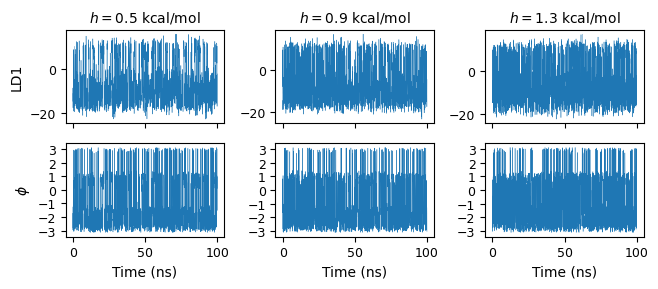

In [32]:
fig, axs = plt.subplots(2, 3, sharex=True,  figsize=(6.69,3.0))
print(axs.shape)
for i in range(len(folders)):
    axs[0,i].set_title(titles[i], fontsize=10)
    axs[0,0].set_ylabel("LD1")
    axs[1,0].set_ylabel("$\phi$")
    axs[0,i].plot(colvar_data[i,0,::10]/1000,  colvar_data[i,1,::10], lw=0.3)
    axs[1,i].plot(colvar_data[i,0,::10]/1000,  colvar_data[i,2,::10], lw=0.3)
    axs[1,i].set_xlabel("Time (ns)")
    axs[1,i].set_yticks(np.arange(-3,4,1))
    
fig.tight_layout()
plt.savefig(os.path.join(output_folder,"metad_ld_vs_time.pdf"))

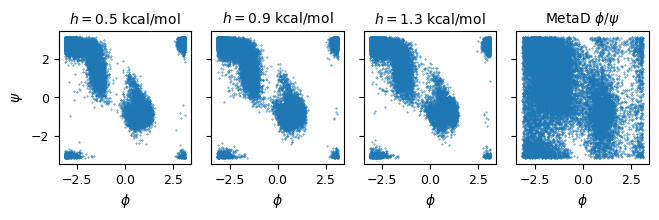

In [35]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(6.69,2.5))

for i in range(len(folders)):
    axs[i].set_title(titles[i], fontsize=10)
    axs[i].scatter(colvar_data[i,2,:],  colvar_data[i,3,:], marker='.', s=0.5)

    axs[i].set_xlabel("$\phi$")
    axs[i].set_aspect("equal")
    
axs[-1].set_title("MetaD $\phi/\psi$", fontsize=10)
axs[-1].scatter(phi_, psi_, marker='.', s=0.5)

axs[-1].set_xlabel("$\phi$")
axs[-1].set_aspect("equal")
axs[0].set_ylabel("$\psi$")

fig.tight_layout()
plt.savefig(os.path.join(output_folder,"metad_scatter.png"),dpi=200)